# Computing energy transfers from triangular mooring array

### Coarse graining method (Aluie et, 2018; Garabato et al, 2022; Savage et al, 2025 (not published)):
The method was developed to compute energy between spatial scales.

Low-pass filter is used to extract the signal for scales larger than l. Filter is noted $\overline{.}_l$. The filter used must respect incompressiblity, i.e $\overline{\nabla . u}_l = \nabla . \overline{u}_l$ .
incompressible Navier-Stokes equation for filtered signal is
\begin{align}
\partial_t\overline{u}_l+(\overline{u}_l . \nabla)\overline{u}_l = -\nabla\overline{p}_l - \nabla . \overline{\tau}_l(u,u)
\end{align}

with $\overline{\tau_l} = \overline{uu_l} - \overline{u}_l\overline{u}_l$, the subgrid/subfilter stress

KE budget scales > l:
\begin{align}
\partial_t(\frac{\vert\overline{u_l}\vert^2}{2})+\partial_j[(\frac{\vert\overline{u_l}\vert^2}{2}+\overline{p})\overline{u}_j+\overline{u}_i\overline{\tau}_{ij}-\nu\partial_j(\frac{\vert\overline{u_l}\vert^2}{2})] = -\Pi_l-\nu\vert\nabla\overline{u}\vert^2
\end{align}

The energy transfer term, $\Pi_l$, accounts for the nonlinear interactions leading to energy transferring from scales larger than l to smaller scales:
\begin{align}
\Pi_l(\vec{x}) = - \overline{S_l}:\overline{\tau_l}(\vec{u},\vec{u})\\
\overline{S_l} = (\nabla\overline{u_l}+\nabla\overline{u_l}^T)/2 \\
\end{align}

It accounts for the large-scale strain tensor acting against subfilter scale stress.

\begin{align}
\Pi_l(\vec{x},t) = -\frac{1}{2}(\nabla_h\overline{u_{hl}}+\nabla_h\overline{u_{hl}}^T):(\overline{u_hu_{hl}}-\overline{u}_{hl} \overline{u}_{hl})
\end{align}

Extension of the theory for energy transfers along frequencies:

\begin{align}
\Pi_\omega=-\frac{1}{2}\begin{pmatrix}2\partial_x u & \partial_y u + \partial_x v \\ \partial_y u + \partial_x v & 2\partial_y v \end{pmatrix} : \begin{pmatrix}\overline{u^2}-\overline{u}^2 & \overline{uv}-\overline{u}\overline{v} \\ \overline{vu}-\overline{v}\overline{u} & \overline{v^2}-\overline{v}^2 \end{pmatrix}\\      
\Pi_\omega=-[(\overline{u^2}-\overline{u}^2)\partial_x u+(\overline{v^2}-\overline{v}^2)\partial_y v+(\overline{uv}-\overline{u}\overline{v})(\partial_y u+\partial_x v)]
\end{align}

If $\Pi_\omega >0$ then there is transfer of energy from low frequencies to high

If $\Pi_\omega <0$ then there is transfer of energy from high frequencies to low

Okubo-Weiss parameter: 

\begin{align}
OW=S_n^2+S^2-\zeta^2
\end{align}

If OW>0 then strain-dominated

If OW<0 the vorticity-dominated

In [98]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
import niskine 

import mplniw.utils as ut
import mplniw.plot as pl
import mplniw.sigp as sp
import gsw
import pandas as pd

In [99]:
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'

In [100]:
alt = niskine.io.load_ssh()
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2)
from datetime import datetime
eke = alt.eke.sel(time=slice('2019-06-01','2020-10-01'))#.plot()
_  = eke.mean('time')

In [101]:
#Combining moorings datasets

lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
moorings={}
cols=['u','v','u_filtered','v_filtered','usq','vsq','usq_filtered','vsq_filtered','uv_filtered']  # variables from which iwe need to remove NaN gaps
for mooring in [1,2,3]:
    ds = xr.open_dataset(root_dir+'M%s_lp05.nc'%mooring)  #loading filtered dataset
    mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))  #loading mixed layer depth at M1 
    ds['mld'] = mld_m1
    for V in cols:
        ds[V] = ds[V].interpolate_na('time',max_gap=pd.Timedelta(12,"h"))  #Interpolating data over gaps in time (flagged profiles)
    moorings[str(mooring)] = ds  #adding dataset to dict
    

In [5]:
#keeping the depth range common to all moorings
for mooring in ['1','2','3']:
    moorings[mooring] = moorings[mooring].where(np.isnan(moorings['3'].u)==False)
    moorings[mooring] = moorings[mooring].where((np.isnan(moorings['2'].u)==False)&(moorings['2'].count('time')>1000))

In [6]:
# Circle radius around moorings
R=gsw.distance([m1lon,m2lon],[m1lat,m2lat])/(2*np.sin(60*np.pi/180))

In [7]:
#Coordinates of the center of the mooring array 
latitudes = [m*np.pi/180 for m in [m1lat,m2lat,m3lat]]
longitudes = [m*np.pi/180 for m in [m1lon,m2lon,m3lon]]
sumx = np.sum(np.cos(latitudes)*np.cos(longitudes))/3
sumy = np.sum(np.cos(latitudes)*np.sin(longitudes))/3
sumz = np.sum(np.sin(latitudes))/3
midlon = 180*np.arctan2(sumy,sumx)/np.pi
hyp = np.sqrt(sumx*sumx+sumy*sumy)
midlat = 180*np.arctan2(sumz,hyp)/np.pi

In [8]:
import cartopy
import shapely
import cartopy.crs as ccrs
import cmocean

#### Horizontal gradients

##### Method 1: Triangle

To compute gradients we need 4 points, coined here: North, South , East and West. Velocity fields (u,v) at missing points are obtained by using an inverse distance weighing interpolation method. East (purple) is obtained by using M1 and M2, North (orange) with M3 and M1, South (green) with M3 and M2, and West is M3 (no interpolation).
Horizontal gradients are computed at the center of the losange (red circle).

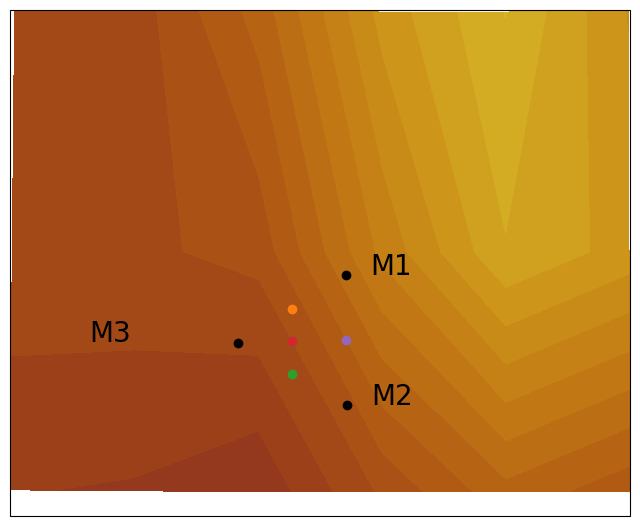

In [40]:
subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-21.0,central_latitude=59.0),
                 facecolor='white')

fig=plt.figure(figsize=[8,8])
p = _.sel(lon=slice(-22,-20.5),lat=slice(58.7,59.4)).plot.contourf(x='lon', y='lat',
                  vmin=0, vmax=5e-2,
                  cmap=cmocean.cm.solar,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  levels=30,
                  add_labels=False,
                  add_colorbar=False)

p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());
p.axes.scatter((m1lon+m3lon)/2,(m1lat+m3lat)/2, transform=ccrs.PlateCarree())
p.axes.scatter((m2lon+m3lon)/2,(m2lat+m3lat)/2, transform=ccrs.PlateCarree())
p.axes.scatter((m2lon+m3lon)/2,(m2lat+2*m3lat+m1lat)/4, transform=ccrs.PlateCarree())
p.axes.scatter((m2lon+m1lon)/2,(m2lat+m1lat)/2, transform=ccrs.PlateCarree())


In [10]:
# Computing distance and horizontal gradients (triangle approximation)
midlon,midlat = (m2lon+m3lon)/2,(m2lat+2*m3lat+m1lat)/4

dM1_N = gsw.distance([(m1lon+m3lon)/2,m1lon],[(m1lat+m3lat)/2,m1lat])
dM3_N = gsw.distance([(m1lon+m3lon)/2,m3lon],[(m1lat+m3lat)/2,m3lat])
dM3_S = gsw.distance([(m2lon+m3lon)/2,m3lon],[(m2lat+m3lat)/2,m3lat])
dM2_S = gsw.distance([(m2lon+m3lon)/2,m2lon],[(m2lat+m3lat)/2,m2lat])

dx_W = gsw.distance([midlon,m3lon],[midlat,midlat])
dx_E = gsw.distance([midlon,(m1lon+m2lon)/2],[midlat,midlat])
#dx_SE = gsw.distance([midlon,m2lon],[midlat,midlat])
#dx_SW = gsw.distance([midlon,m3lon],[midlat,midlat])
#dx_NW = gsw.distance([midlon,m3lon],[midlat,midlat])

dy_NE = gsw.distance([midlon,midlon],[midlat,m1lat])
dy_SE = gsw.distance([midlon,midlon],[midlat,m2lat])

In [11]:
ueast = (moorings['1'].u_filtered*dy_SE+moorings['2'].u_filtered*dy_NE)/(dy_NE+dy_SE)
veast = (moorings['1'].v_filtered*dy_SE+moorings['2'].v_filtered*dy_NE)/(dy_NE+dy_SE)

uwest = moorings['3'].u_filtered
vwest = moorings['3'].v_filtered

unorth = (moorings['1'].u_filtered*dM3_N+moorings['3'].u_filtered*dM1_N)/(dM1_N+dM3_N)
vnorth = (moorings['1'].v_filtered*dM3_N+moorings['3'].v_filtered*dM1_N)/(dM1_N+dM3_N)

usouth = (moorings['2'].u_filtered*dM3_S+moorings['3'].u_filtered*dM2_S)/(dM2_S+dM3_S)
vsouth = (moorings['2'].v_filtered*dM3_S+moorings['3'].v_filtered*dM2_S)/(dM2_S+dM3_S)

ux_1 = (ueast-uwest)/((dx_W+dx_E))
vx_1 = (veast-vwest)/((dx_W+dx_E))
uy_1 = (unorth-usouth)/((dy_NE+dy_SE)/2)
vy_1 = (vnorth-vsouth)/((dy_NE+dy_SE)/2)

RV_1 = vx_1-uy_1
fc_1=ut.coriolis(midlat)

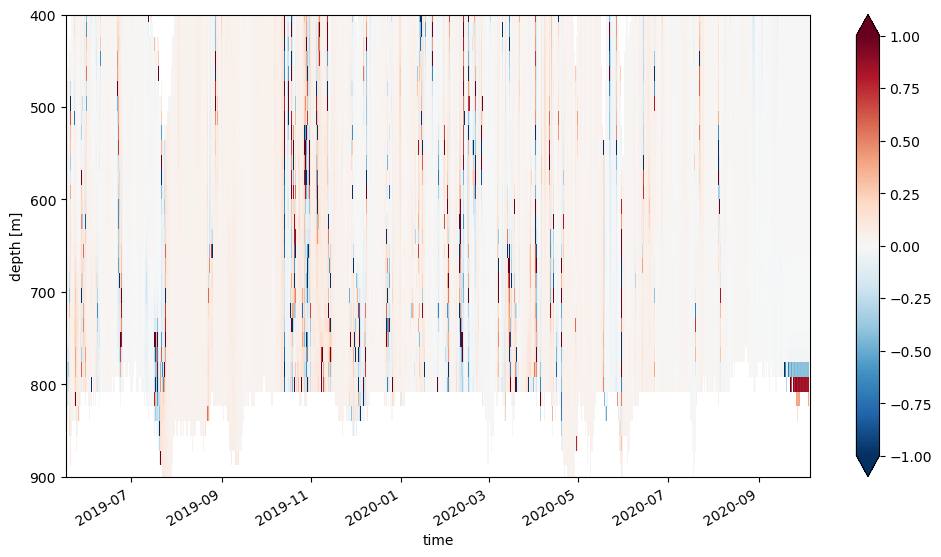

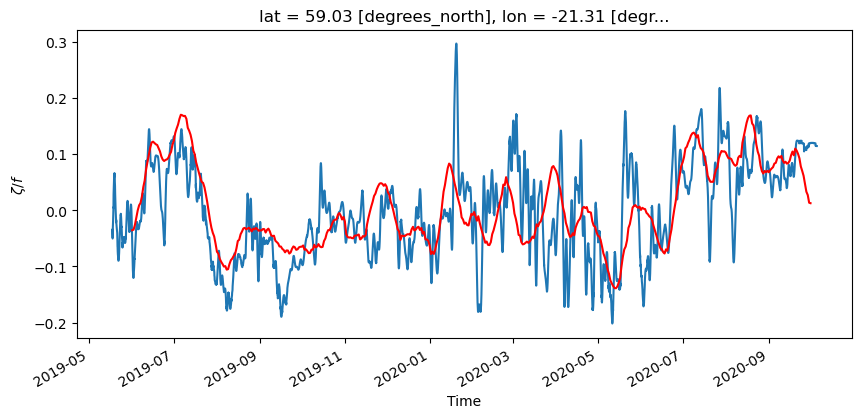

In [12]:
#Checking differences between RV and vorticity methods

vort=xr.open_dataset(root_dir+'vorticity_moorings.nc')
vort_alt=xr.open_dataset(root_dir+'vorticity_alt.nc')

fig,ax=plt.subplots(figsize=(12,6))
((RV_1-vort.vorticity)/vort.vorticity).plot(ax=ax,yincrease=False,ylim=(900,400),vmax=1)
plt.figure(figsize=(10,4))
(RV_1/fc_1).mean('z').plot()
(vort_alt.interp(lat=midlat,lon=midlon).__xarray_dataarray_variable__).plot(c='r')

##### Method 2: Square

This method creates a square from moorings points, with 4 points used to compute Nnorth, south, and east velocity fields, M3 is used for Northwest, West and Southwest points.
Horizontal graidents are then computed at the middle of the square.

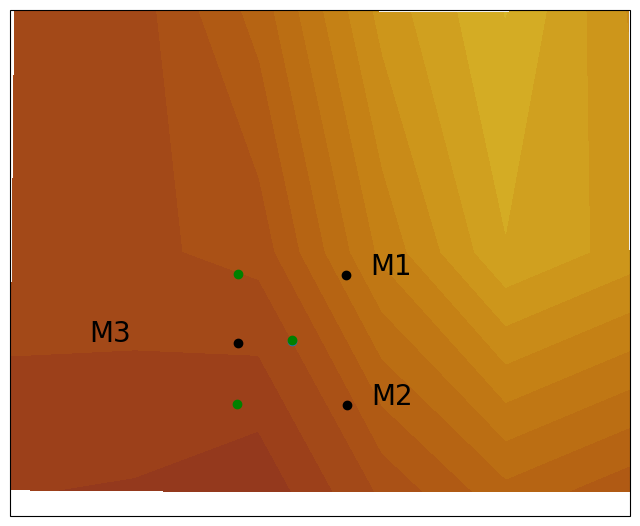

In [13]:


fig=plt.figure(figsize=[8,8])
p = _.sel(lon=slice(-22,-20.5),lat=slice(58.7,59.4)).plot.contourf(x='lon', y='lat',
                  vmin=0, vmax=5e-2,
                  cmap=cmocean.cm.solar,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  levels=30,
                  add_labels=False,
                  add_colorbar=False)

p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());
p.axes.scatter(m3lon,m1lat,c='g', transform=ccrs.PlateCarree());
p.axes.scatter(m3lon,m2lat,c='g', transform=ccrs.PlateCarree());
midlon_sq,midlat_sq=(m3lon+m1lon)/2,(m2lat+m1lat)/2
p.axes.scatter(midlon_sq,midlat_sq,c='g', transform=ccrs.PlateCarree());
#p.axes.plot(R*np.cos(np.linspace(0,2*np.pi,50))+midlon,R*np.sin(np.linspace(0,2*np.pi,50))+midlat,transform=ccrs.PlateCarree());
#circle_points = cartopy.geodesic.Geodesic().circle(lon=midlon, lat=midlat, radius=R, n_samples=50, endpoint=False)
#geom = shapely.geometry.Polygon(circle_points)
#p.axes.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1)


In [14]:
# Computing distance and horizontal gradients (square approximation)
dx_NE = gsw.distance([midlon_sq,m1lon],[midlat_sq,midlat_sq])
dx_SE = gsw.distance([midlon_sq,m2lon],[midlat_sq,midlat_sq])
dx_SW = gsw.distance([midlon_sq,m3lon],[midlat_sq,midlat_sq])
dx_NW = gsw.distance([midlon_sq,m3lon],[midlat_sq,midlat_sq])

dy_NE = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m1lat])
dy_SE = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m2lat])
dy_SW = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m2lat])
dy_NW = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m1lat])

In [15]:
ueast = (moorings['1'].u_filtered*dy_SE+moorings['2'].u_filtered*dy_NE)/(dy_NE+dy_SE)
veast = (moorings['1'].v_filtered*dy_SE+moorings['2'].v_filtered*dy_NE)/(dy_NE+dy_SE)

uwest = moorings['3'].u_filtered
vwest = moorings['3'].v_filtered

unorth = (moorings['1'].u_filtered*dx_NW+moorings['3'].u_filtered*dx_NE)/(dx_NE+dx_NW)
vnorth = (moorings['1'].v_filtered*dx_NW+moorings['3'].v_filtered*dx_NE)/(dx_NE+dx_NW)

usouth = (moorings['2'].u_filtered*dx_SW+moorings['3'].u_filtered*dx_SE)/(dx_SE+dx_SW)
vsouth = (moorings['2'].v_filtered*dx_SW+moorings['3'].v_filtered*dx_SE)/(dx_SE+dx_SW)

In [16]:
ux = (ueast-uwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
vx = (veast-vwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
uy = (unorth-usouth)/((dy_NE+dy_SE))
vy = (vnorth-vsouth)/((dy_NE+dy_SE))



In [17]:
RV = vx-uy

In [18]:
fc=ut.coriolis(midlat_sq)

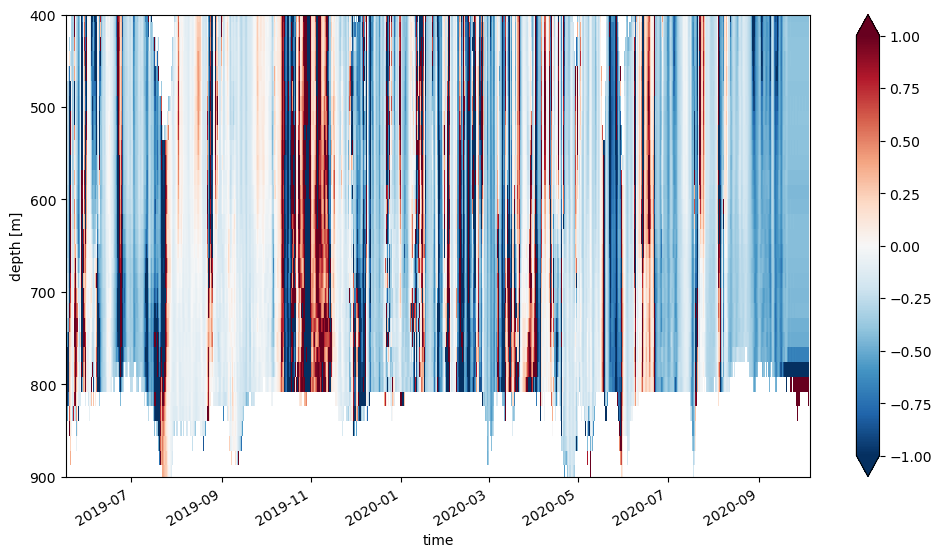

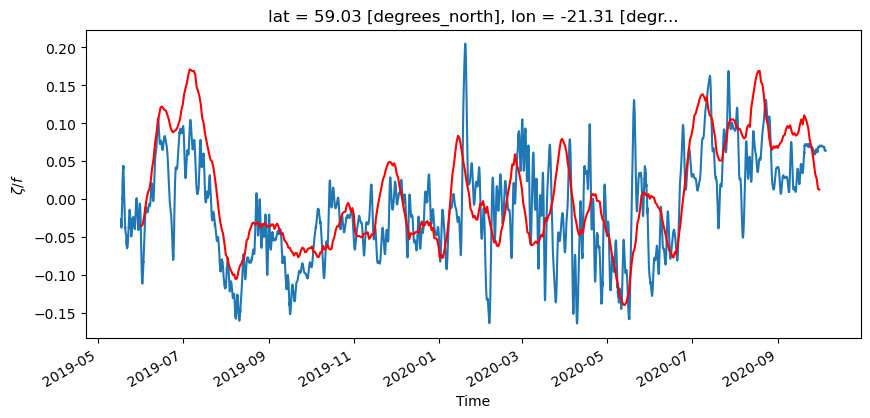

In [19]:

fig,ax=plt.subplots(figsize=(12,6))
((RV-vort.vorticity)/vort.vorticity).plot(ax=ax,yincrease=False,ylim=(900,400),vmax=1)
plt.figure(figsize=(10,4))
(RV/fc).mean('z').plot()
(vort_alt.interp(lat=midlat_sq,lon=midlon_sq).__xarray_dataarray_variable__).plot(c='r')

#### Interpolation ot the center of the array

In [20]:
#adding lon and lat dimensions to datasets
moorings['1']=moorings['1'].assign_coords({'lat':m1lat,'lon':m1lon}).expand_dims({'lat':1,'lon':1})
moorings['2']=moorings['2'].assign_coords({'lat':m2lat,'lon':m2lon}).expand_dims({'lat':1,'lon':1})
moorings['3']=moorings['3'].assign_coords({'lat':m3lat,'lon':m3lon}).expand_dims({'lat':1,'lon':1})

In [21]:
def get_mid(moorings,mlat=midlat,mlon=midlon,col='usq'):
    """ Interpolate variable at the center  of the mooring triangular array using all moorings measurements.
    ----------------------------------------------------
    Parameters:
    moorings: dict, contains the three moorings xarray datasets
    col:str, variable to interpolate
    ----------------------------------------------------
    Returns:
    ds_mid:DataArray, interpolated variable
    """
    ds_mid=xr.merge([moorings['1'][col],moorings['2'][col],moorings['3'][col]])
    ds_mid[col]=ds_mid[col].interpolate_na(dim='time',max_gap=pd.Timedelta('1D'))
    ds_mid[col]=ds_mid[col].fillna(0).interp(lat=mlat,lon=mlon,method='slinear')
    ds_mid[col]=ds_mid[col].where(ds_mid[col]!=0)
    return ds_mid[col]

In [22]:
# interpolating needed variables to the center of the square mooring array
usqf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='usq_filtered')  #filtered u squared
vsqf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='vsq_filtered')  #filtered v squared
uvf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='uv_filtered')    #filtered u*v
uf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='u_filtered')  #filtered u
vf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='v_filtered')  #filtered v
usq_mid =get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='usq')   #raw u squared
vsq_mid =get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='vsq')   #raw v squared

In [23]:
# interpolating needed variables to the center of the triangular mooring array
usqf_mid_1=get_mid(moorings,col='usq_filtered')  #filtered u squared
vsqf_mid_1=get_mid(moorings,col='vsq_filtered')  #filtered v squared
uvf_mid_1=get_mid(moorings,col='uv_filtered')    #filtered u*v
uf_mid_1=get_mid(moorings,col='u_filtered')  #filtered u
vf_mid_1=get_mid(moorings,col='v_filtered')  #filtered v
usq_mid_1 =get_mid(moorings,col='usq')   #raw u squared
vsq_mid_1 =get_mid(moorings,col='vsq')   #raw v squared

#### Energy transfers estimates

In [25]:
# Computing energy transfer rate (square array)

Sn = ux-vy #normal components of strain
S = uy+vx #shear component of strain
RV = vx-uy  #Relative vorticity
OW = Sn**2+S**2-RV**2 #OW parameter
P = -((usqf_mid-uf_mid**2)*ux + (vsqf_mid-vf_mid**2)*vy + (uvf_mid-uf_mid*vf_mid)*(uy+vx))

In [26]:
# Computing energy transfer rate (triangular array)

Sn_1 = ux_1-vy_1 #normal components of strain
S_1 = uy_1+vx_1 #shear component of strain
OW_1 = Sn_1**2+S_1**2-RV_1**2 #OW parameter
P_1 = -((usqf_mid-uf_mid**2)*ux_1 + (vsqf_mid-vf_mid**2)*vy_1 + (uvf_mid-uf_mid*vf_mid)*(uy_1+vx_1))

### Visualisation: Statistical analysis

Text(0.5, 1.0, 'Normalized relative vorticity')

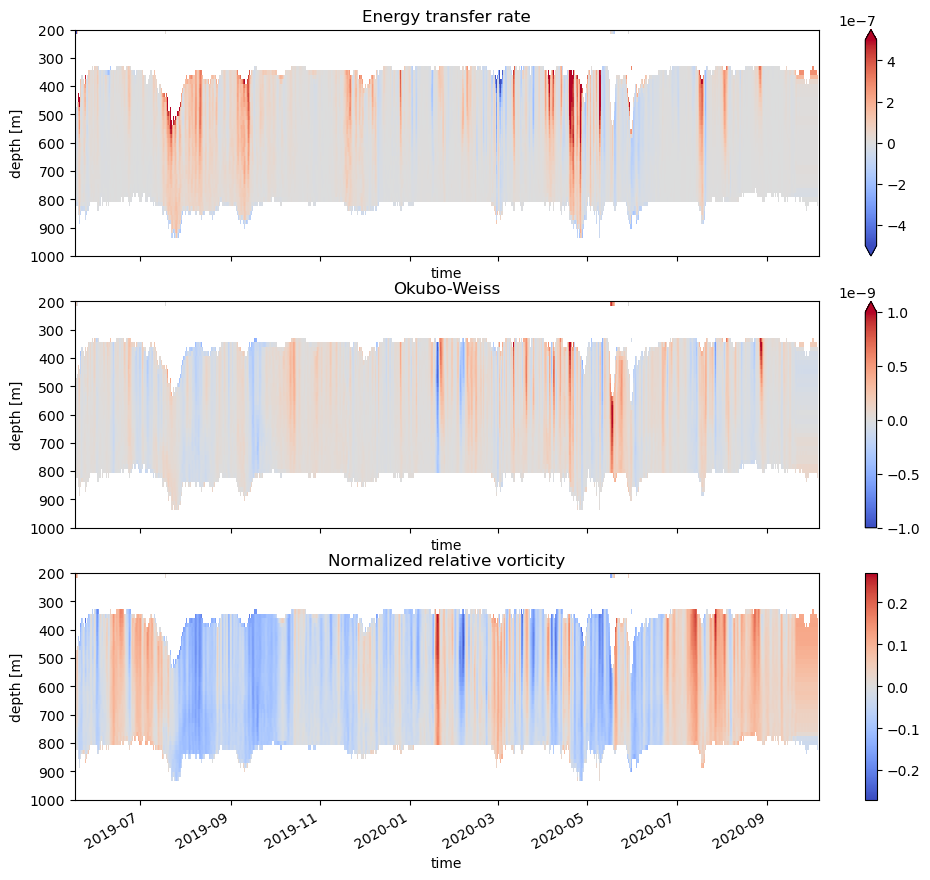

In [27]:
# 2D Energy transfers, OW and vorticity (square)
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=5e-7,cmap='coolwarm')
ax.set_title('Energy transfer rate')
ax=axs[1]
OW.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-9,cmap='coolwarm')
ax.set_title('Okubo-Weiss')
ax=axs[2]
(RV/fc).plot(ax=ax,yincrease=False,ylim=(1000,200),cmap='coolwarm')
ax.set_title('Normalized relative vorticity')

Text(0.5, 1.0, 'Normalized relative vorticity')

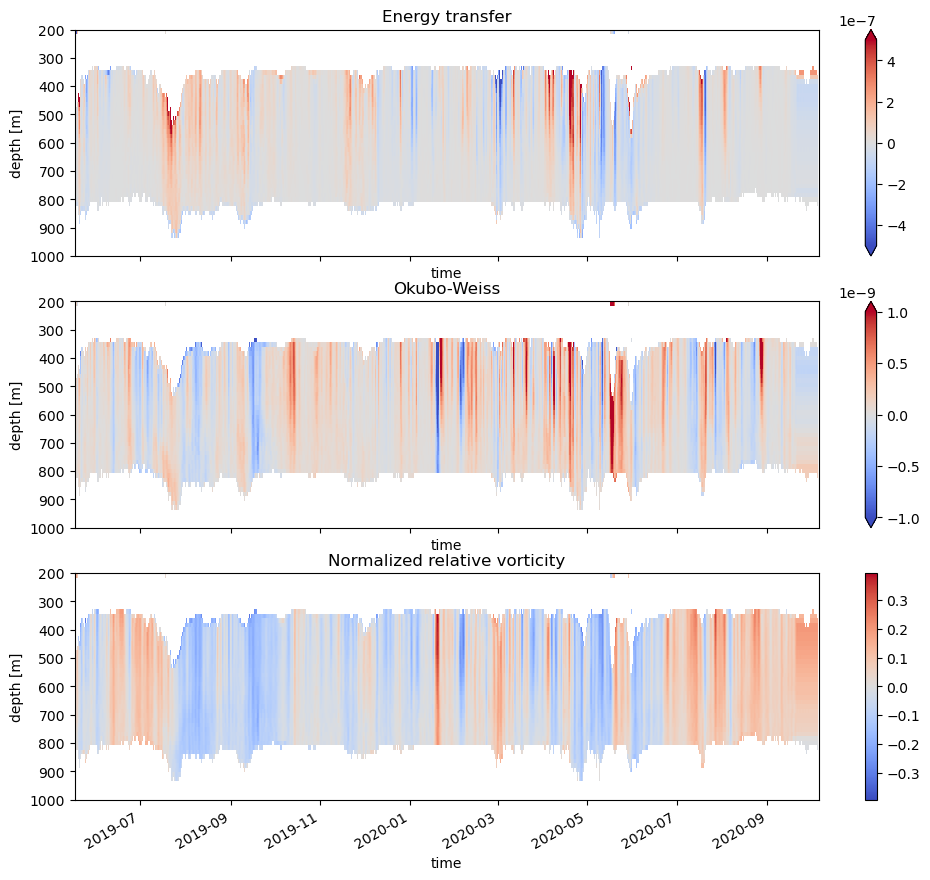

In [28]:
# 2D Energy transfers, OW and vorticity (triangle)
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=5e-7,cmap='coolwarm')
ax.set_title('Energy transfer')
ax=axs[1]
OW_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-9,cmap='coolwarm')
ax.set_title('Okubo-Weiss')
ax=axs[2]
(RV_1/fc_1).plot(ax=ax,yincrease=False,ylim=(1000,200),cmap='coolwarm')
ax.set_title('Normalized relative vorticity')

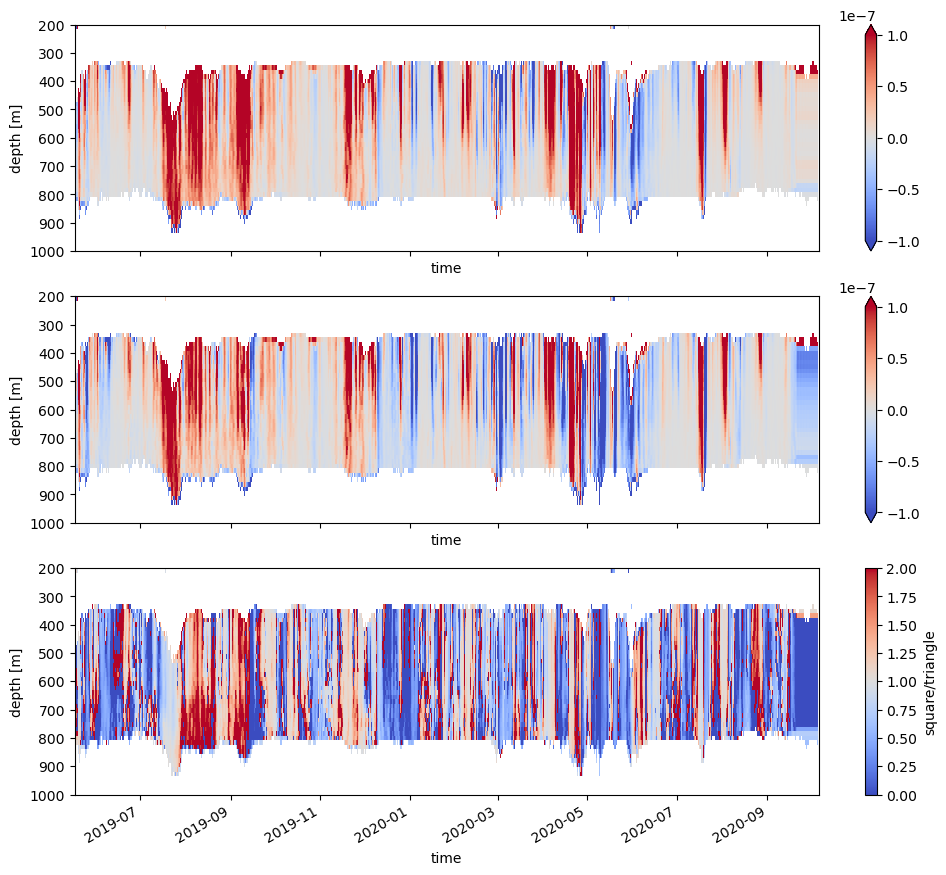

In [29]:
#Comparison of energy transfers for both methods
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-7,cmap='coolwarm')
ax=axs[1]
P_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-7,cmap='coolwarm')
ax=axs[2]
cs=(P/P_1).plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=2,vmin=0,cmap='coolwarm',add_colorbar=False)
plt.colorbar(cs,label="square/triangle")

Text(0.5, 1.0, 'Triangle')

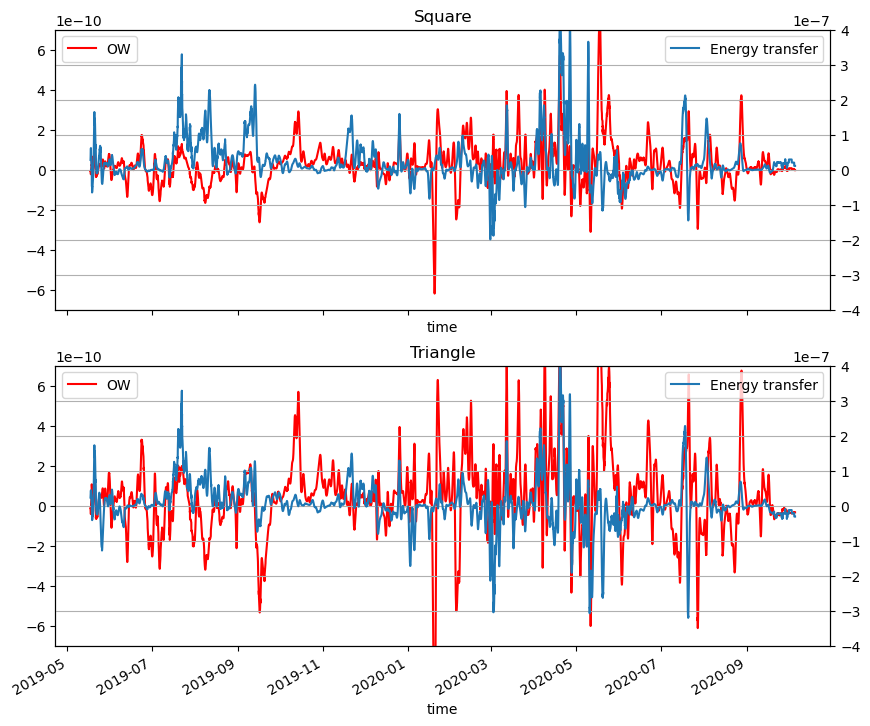

In [31]:
#Looking for a link between OW and energy transfer signs
fig,axs=plt.subplots(2,1,figsize=(10,8),sharex=True)
OW.mean('z').plot(ax=axs[0],c='r',ylim=(-7e-10,7e-10),label='OW')
axs[0].legend(loc=2)
ax1=axs[0].twinx()
P.mean('z').plot(ax=ax1,ylim=(-4e-7,4e-7),label='Energy transfer')
ax1.grid();ax1.legend(loc=1)
axs[0].set_title('Square')

OW_1.mean('z').plot(ax=axs[1],c='r',ylim=(-7e-10,7e-10),label='OW')
axs[1].legend(loc=2)
ax1=axs[1].twinx()
P_1.mean('z').plot(ax=ax1,ylim=(-4e-7,4e-7),label='Energy transfer')
ax1.grid();ax1.legend(loc=1)
axs[1].set_title('Triangle')

#### Time-averaged profiles

Text(0.5, 0.98, 'Triangle')

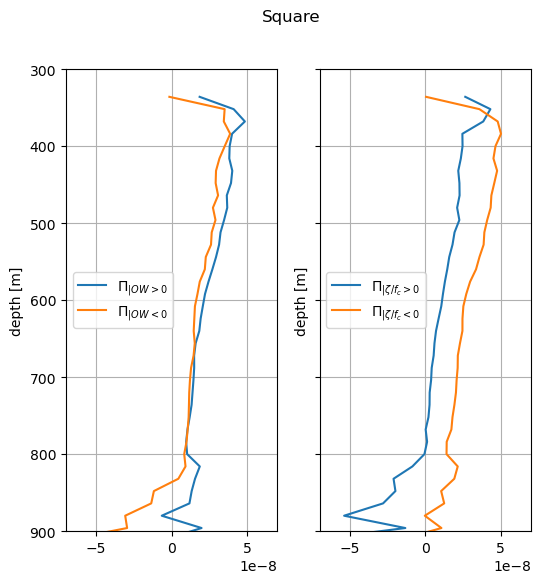

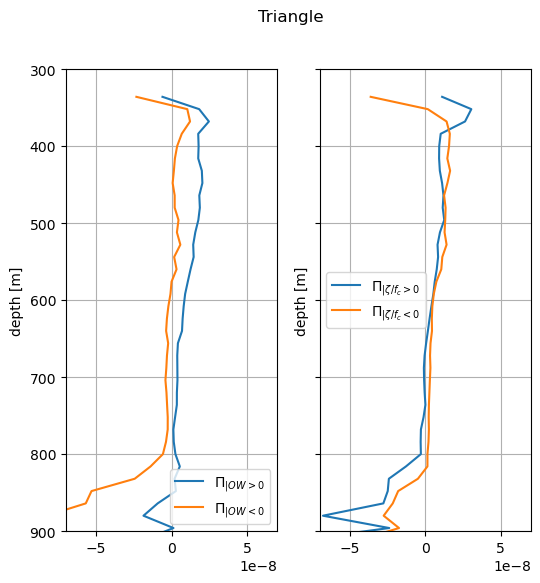

In [32]:
#Dependance to OW and vorticity sign
fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
P.where(OW>0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW>0}$')
P.where(OW<0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid();ax[0].set_xlim(-7e-8,7e-8);ax[1].set_xlim(-7e-8,7e-8)
P.where((RV/fc)>0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c>0}$')
P.where((RV/fc)<0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid();
fig.suptitle('Square')

fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
P_1.where(OW_1>0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW>0}$')
P_1.where(OW_1<0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid()
P_1.where((RV_1/fc_1)>0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c>0}$')
P_1.where((RV_1/fc_1)<0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid();ax[0].set_xlim(-7e-8,7e-8);ax[1].set_xlim(-7e-8,7e-8)
fig.suptitle('Triangle')

Text(0.5, 1.0, 'Triangle')

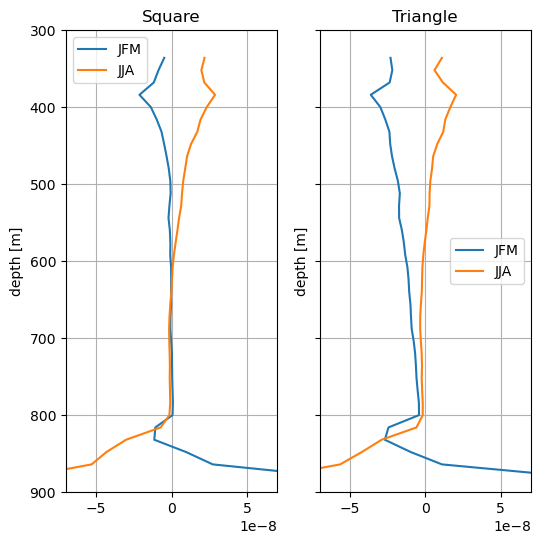

In [41]:
#Seasonality
fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
P.sel(time=slice('2020-01','2020-03')).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'JFM')
P.sel(time=slice('2020-06','2020-08')).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'JJA')
ax[0].legend();ax[0].grid();ax[0].set_xlim(-7e-8,7e-8);ax[1].set_xlim(-7e-8,7e-8)
ax[0].set_title('Square')

P_1.sel(time=slice('2020-01','2020-03')).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'JFM')
P_1.sel(time=slice('2020-06','2020-08')).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'JJA')
ax[1].legend();ax[1].grid();
ax[1].set_title('Triangle')

#### Histograms

In [42]:
import seaborn as sns

Text(0.5, 0.98, 'Energy transfer PDF: Triangle method')

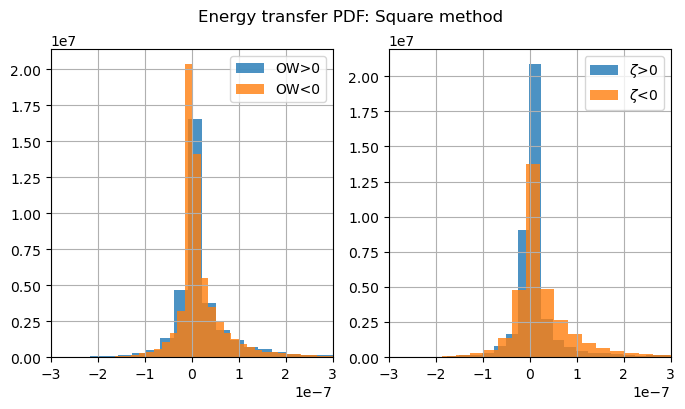

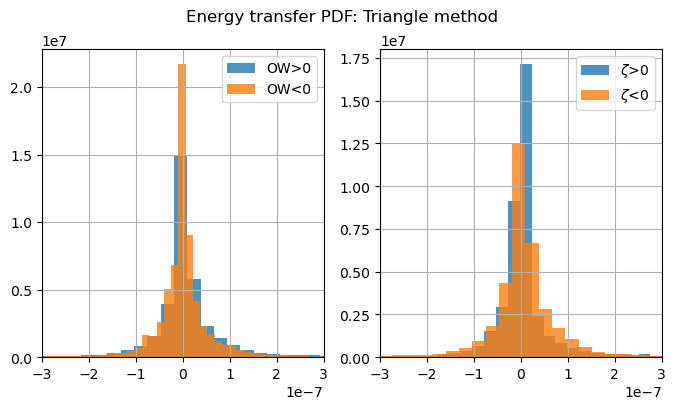

In [72]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
axs[0].grid()
ax=P.where(OW>0).plot.hist(ax=axs[0],density=True,bins=100,alpha=0.8,label='OW>0')
ax=P.where(OW<0).plot.hist(ax=axs[0],density=True,bins=100,alpha=0.8,label='OW<0')
axs[0].set_xlim(-3e-7,3e-7);axs[0].legend()

axs[1].grid()
ax=P.where(RV>0).plot.hist(ax=axs[1],density=True,bins=100,alpha=0.8,label=r'$\zeta$>0')
ax=P.where(RV<0).plot.hist(ax=axs[1],density=True,bins=100,alpha=0.8,label=r'$\zeta$<0')
axs[1].set_xlim(-3e-7,3e-7);axs[1].legend()
fig.suptitle('Energy transfer PDF: Square method')

fig,axs=plt.subplots(1,2,figsize=(8,4))
axs[0].grid()
ax=P_1.where(OW_1>0).plot.hist(ax=axs[0],density=True,bins=100,alpha=0.8,label='OW>0')
ax=P_1.where(OW_1<0).plot.hist(ax=axs[0],density=True,bins=100,alpha=0.8,label='OW<0')
axs[0].set_xlim(-3e-7,3e-7);axs[0].legend()

axs[1].grid()
ax=P_1.where(RV_1>0).plot.hist(ax=axs[1],density=True,bins=100,alpha=0.8,label=r'$\zeta$>0')
ax=P_1.where(RV_1<0).plot.hist(ax=axs[1],density=True,bins=100,alpha=0.8,label=r'$\zeta$<0')
axs[1].set_xlim(-3e-7,3e-7);axs[1].legend()
fig.suptitle('Energy transfer PDF: Triangle method')

### Event-focused study

Text(0.5, 0.98, 'Square method: energy transfers (OW,$\\zeta$)')

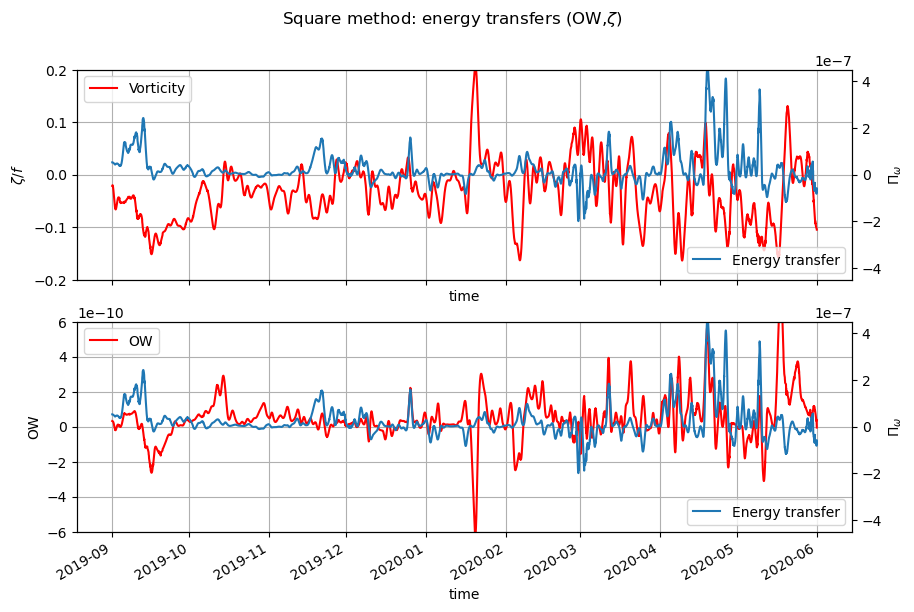

In [80]:
#Zoom in NIWs active period

fig,axs=plt.subplots(2,1,figsize=(10,6),sharex=True)
ax=axs[0]
(RV/fc).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='Vorticity')
ax.set_ylim(-0.2,0.2)
ax1=ax.twinx()
P.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'$\zeta/f$')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='lower right')

ax=axs[1]
(OW).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='OW')
ax.set_ylim(-6e-10,6e-10)
ax1=ax.twinx()
P.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'OW')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='lower right')

fig.suptitle(r'Square method: energy transfers (OW,$\zeta$)')

Text(0.5, 0.98, 'Triangle method: energy transfers (OW,$\\zeta$)')

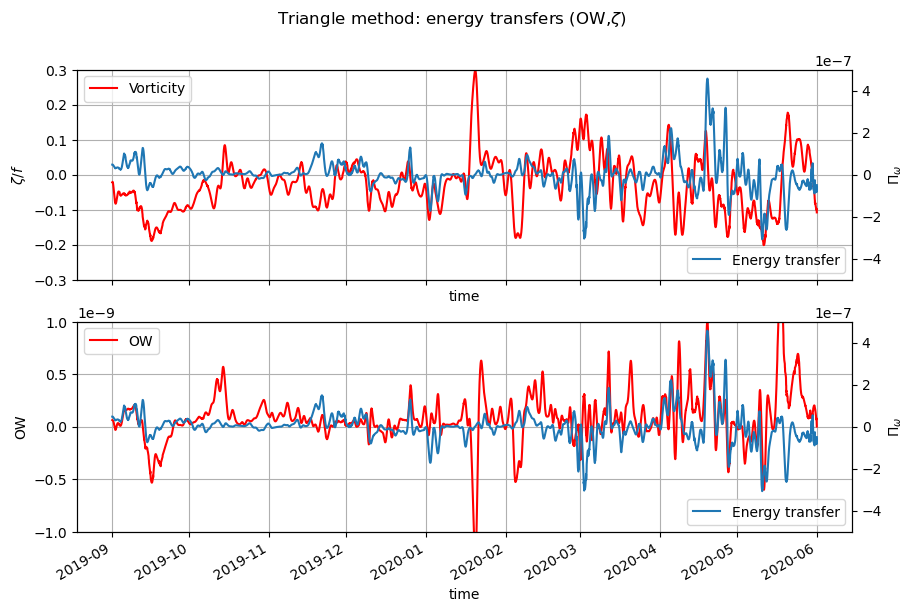

In [88]:
fig,axs=plt.subplots(2,1,figsize=(10,6),sharex=True)
ax=axs[0]
(RV_1/fc_1).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='Vorticity')
ax.set_ylim(-0.3,0.3)
ax1=ax.twinx()
P_1.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-5e-7,5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'$\zeta/f$')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='lower right')

ax=axs[1]
(OW_1).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='OW')
ax.set_ylim(-1e-9,1e-9)
ax1=ax.twinx()
P_1.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-5e-7,5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'OW')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='lower right')

fig.suptitle(r'Triangle method: energy transfers (OW,$\zeta$)')

#### Comparing to NI KE distribution

In [103]:
ds=xr.open_dataset('/Users/zcasparcohen/codes/NIW/'+'data/NI02_M1.nc')

Text(0.5, 0.98, 'Square method')

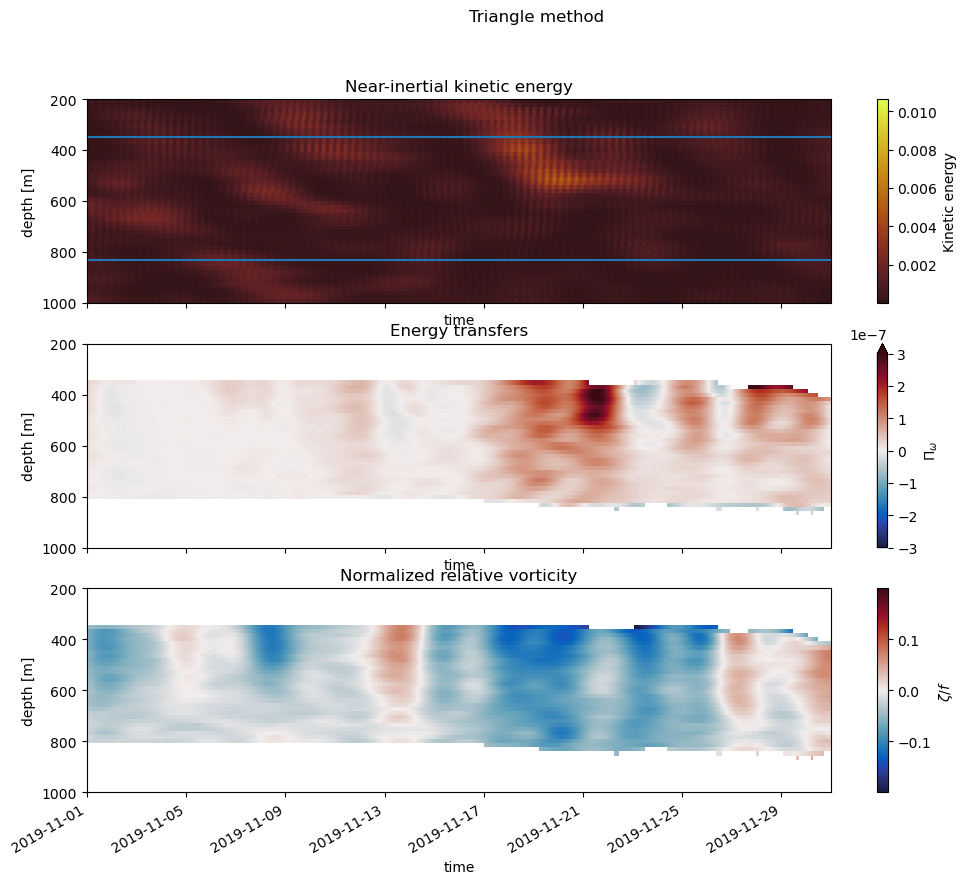

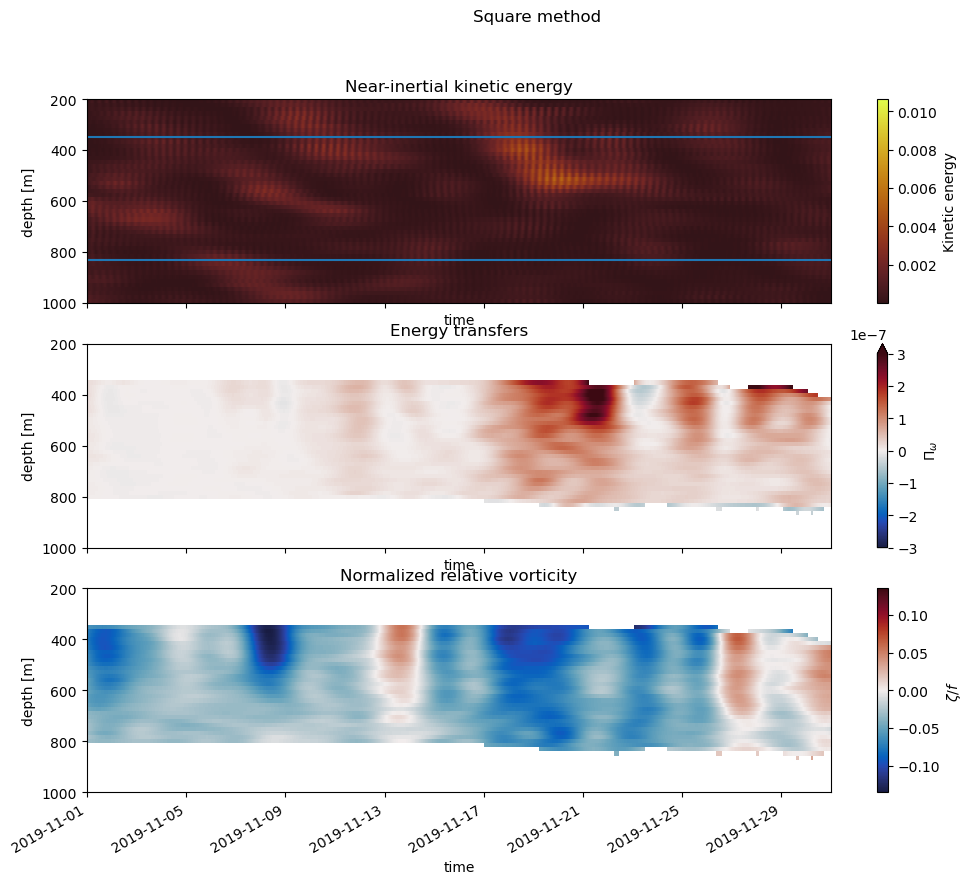

In [104]:
#November 2019 event
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='11-2019').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar,cbar_kwargs={'label':'Kinetic energy'})
ax[0].set_title('Near-inertial kinetic energy')
P_1.sel(time='11-2019').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance,cbar_kwargs={'label':r'$\Pi_\omega$'})
ax[1].set_title('Energy transfers')
(RV_1/fc_1).sel(time='11-2019').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance,cbar_kwargs={'label':r'$\zeta/f$'})
ax[2].set_title('Normalized relative vorticity')
ax[0].axhline(350);ax[0].axhline(830)
fig.suptitle('Triangle method')

fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='11-2019').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar,cbar_kwargs={'label':'Kinetic energy'})
ax[0].set_title('Near-inertial kinetic energy')
P.sel(time='11-2019').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance,cbar_kwargs={'label':r'$\Pi_\omega$'})
ax[1].set_title('Energy transfers')
(RV/fc).sel(time='11-2019').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance,cbar_kwargs={'label':r'$\zeta/f$'})
ax[2].set_title('Normalized relative vorticity')
ax[0].axhline(350);ax[0].axhline(830)
fig.suptitle('Square method')

### Dev

(-4e-07, 4e-07)

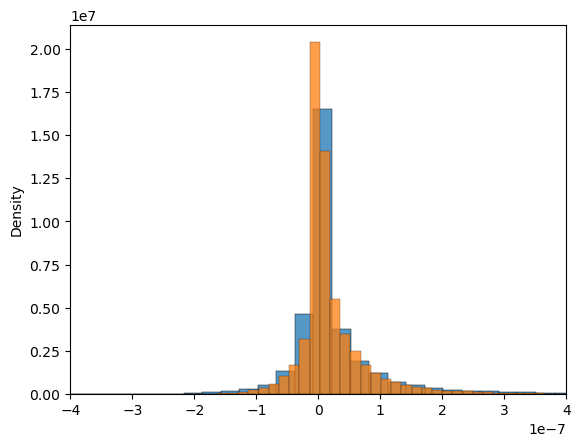

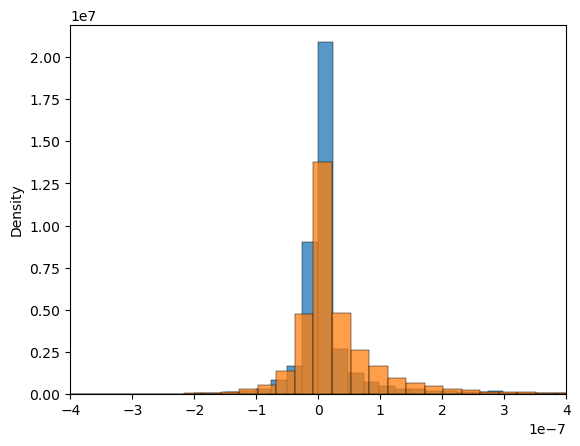

In [36]:
#Histogram depending on OW signs (for the square method)
axes=sns.histplot(P.where(OW>0).values.flatten(),bins=100,stat='density',label='OW>0')
axes1=sns.histplot(P.where(OW<0).values.flatten(),bins=100,stat='density',label='OW<0')
axes.set_xlim(-4e-7,4e-7)

#Histogram depending on vorticity signs (for the sqauure method)
plt.figure()
axes=sns.histplot(P.where(RV>0).values.flatten(),bins=100,stat='density',label='RV>0')
axes1=sns.histplot(P.where(RV<0).values.flatten(),bins=100,stat='density',label='RV<0')
axes.set_xlim(-4e-7,4e-7)

(-4e-07, 4e-07)

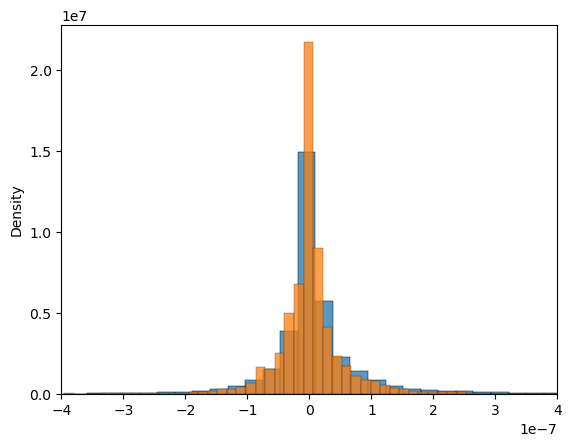

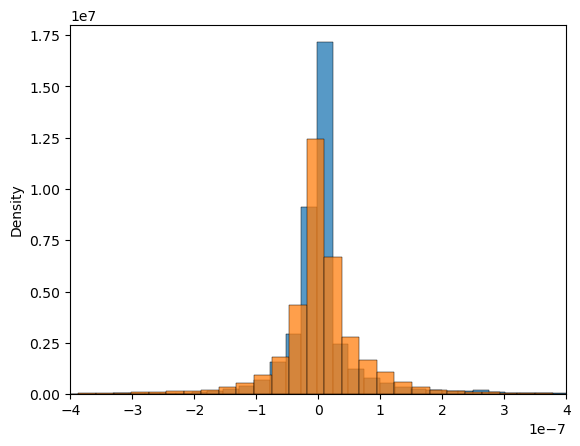

In [37]:
#Histogram depending on OW signs (for the triangular method)
axes=sns.histplot(P_1.where(OW_1>0).values.flatten(),bins=100,stat='density',label='OW>0')
axes1=sns.histplot(P_1.where(OW_1<0).values.flatten(),bins=100,stat='density',label='OW<0')
axes.set_xlim(-4e-7,4e-7)

#Histogram depending on vorticity sign (for the triangular method)
plt.figure()
axes=sns.histplot(P_1.where(RV_1>0).values.flatten(),bins=100,stat='density',label='RV>0')
axes1=sns.histplot(P_1.where(RV_1<0).values.flatten(),bins=100,stat='density',label='RV<0')
axes.set_xlim(-4e-7,4e-7)

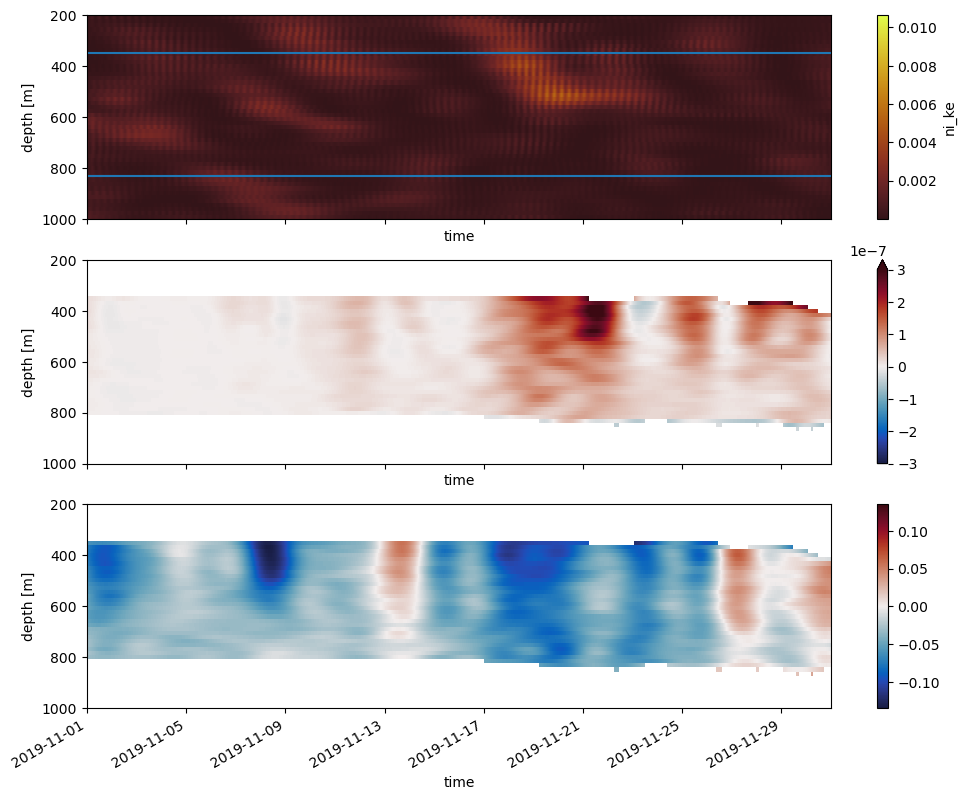

In [163]:
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='11-2019').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar)
P.sel(time='11-2019').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance)
(RV/fc).sel(time='11-2019').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance)
ax[0].axhline(350);ax[0].axhline(830)

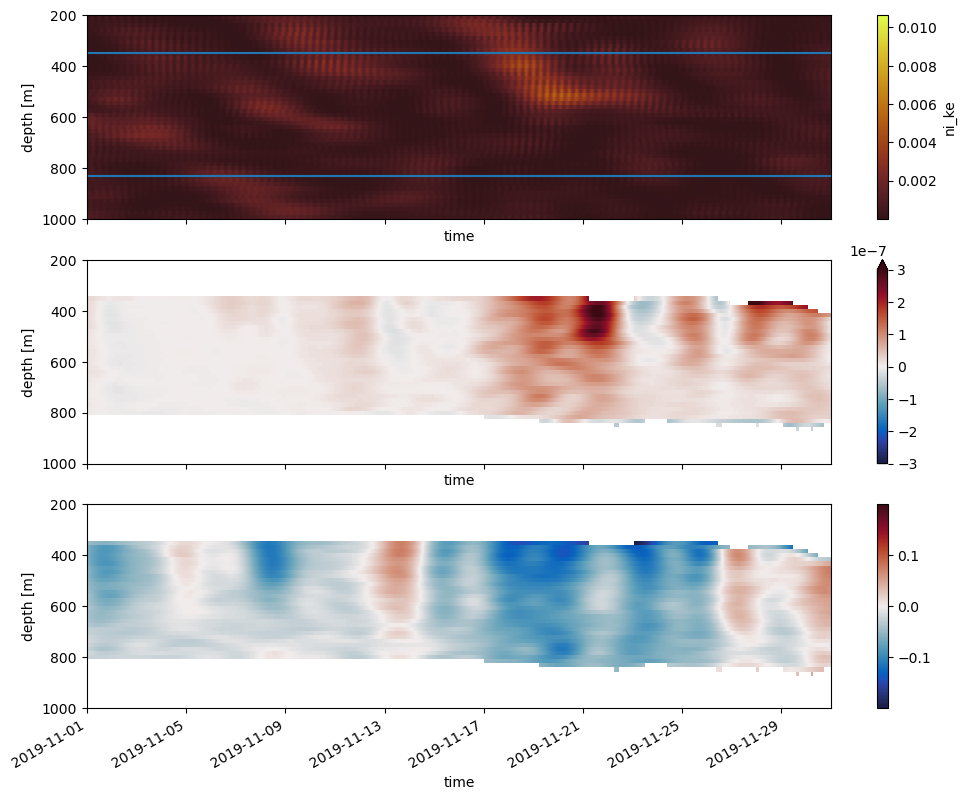

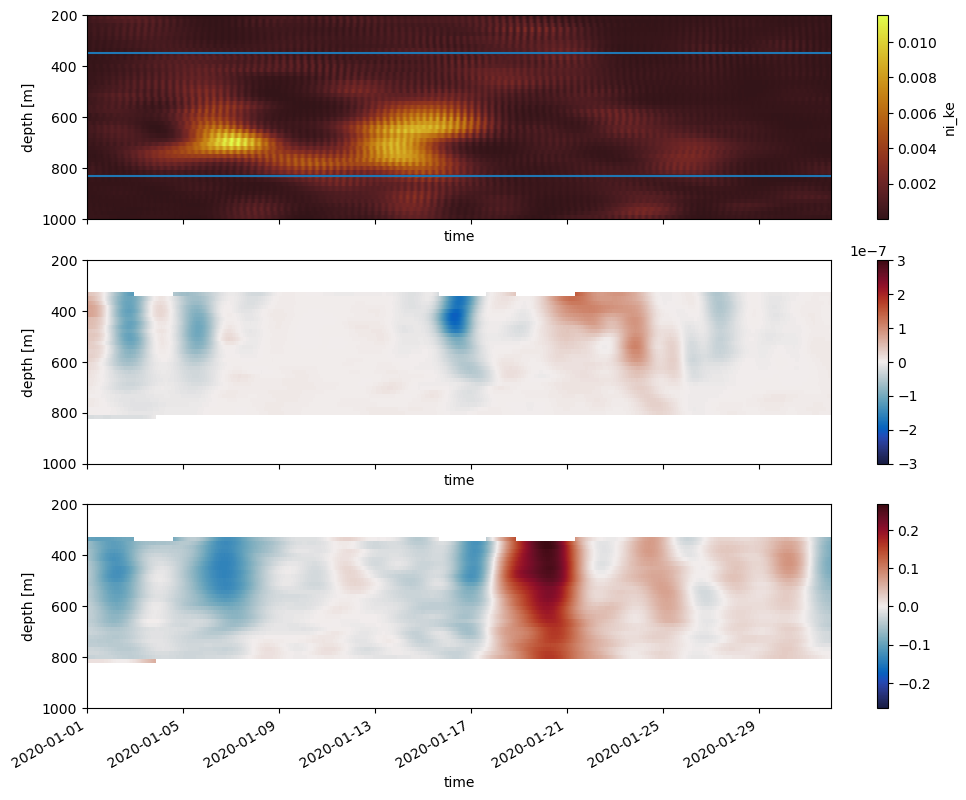

In [167]:
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='01-2020').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar)
P.sel(time='01-2020').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance)
(RV/fc).sel(time='01-2020').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance)
ax[0].axhline(350);ax[0].axhline(830)

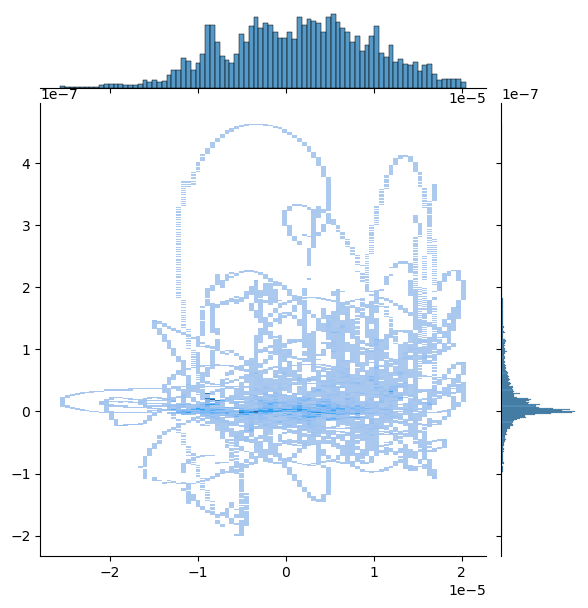

In [161]:
sns.jointplot(x=OW.mean('z').values.flatten(),y=P.mean('z').values.flatten(),kind='hist',stat='density')